<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_PCA_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extract features from pcap files

#IoT-23 Data preprocessing
- Collection
- Cleaning
- Encoding
- Scaling
- Normalisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 1: Data Collection
data_file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 8GB Dataset/CTU-IoT-Malware-Capture-35-1-log.txt'
#Read the file
df = pd.read_csv(
    data_file_path,
    sep="\t",
    comment="#",
    header=None,
    names=[
        "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
        "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
        "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
        "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
    ]
)

# #TEST:
# # List of file paths
# data_file_paths = [
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/Benign_Dataset13.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/DoS_Dataset21.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/GafgytBotnet_Dataset3.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiBotnet_Dataset1.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/MiraiVariant_Dataset5.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/OkiruBotnet_Dataset17.csv',
#     '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 Preprocessed Dataset/PartOfMioriBotnet_Dataset20.csv'

# ]
# dfs = []#set the df list var

# for file_path in data_file_paths: # Loop through the file paths and add the data to a temp df var
#   try:
#       temp_df = pd.read_csv(
#           file_path,
#           sep=",",
#           comment="#",
#           header=0,# Use the first non-comment line as the header
#           names=[
#               "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
#               "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
#               "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
#               "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
#           ]
#       )
#       dfs.append(temp_df) #add the info in the temp df to the dfs list
#       print(f"Loaded file: {file_path} with {len(temp_df)} rows")
#   except Exception as e:
#       print(f"Error reading file {file_path}: {e}")

# # Concatenate all dataframes into one
# df = pd.concat(dfs, ignore_index=True) #make the list of dataframes into one big dataframe


print("\nInitial sample:")
print(df.head().to_string())

# Step 2: Data Cleaning
# Convert timestamp to datetime
df["ts"] = pd.to_datetime(df["ts"], unit="s", errors='coerce')

# Drop non-informative or redundant columns
df.drop(columns=['uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'history'], inplace=True)

# Replace '-' with NaN for consistent handling
df.replace('-', np.nan, inplace=True)

# Drop rows where critical numeric fields are missing
df.dropna(subset=[
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
], inplace=True)

# Convert appropriate columns to numeric types
numeric_columns = [
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'missed_bytes'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Encode categorical columns
categorical_columns = ['proto', 'conn_state', 'service']
for col in categorical_columns:
    df[col] = df[col].astype(str)  # Ensure strings
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert label to binary (malicious=1, benign=0)
df['label'] = df['label'].apply(lambda x: 1 if 'Malicious' in str(x) else 0)

# Drop any rows still containing NaN
df.dropna(inplace=True)

print("\nCleaned sample:")
print(df.head().to_string())
print("\nData types and nulls:")
print(df.info())
# print("\nStatistics:")
# print(df.describe().to_string())


# --- Split features and labels ---
X = df.drop(columns=['label', 'ts']).values  # Drop label and timestamp
y = df['label'].values

# --- Train/Validation/Test Split --- #TEST
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Split test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Split validation set (20% of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)
# Shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# --- Normalize ---
# X_scaled = StandardScaler().fit_transform(X) #standardise data features
#TEST
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Calculate the mean and standard deviation of each feature in the training set
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# --- Add counts of malware and benign logs ---
total_logs = len(df)
malware_logs = df['label'].sum()  # since malware=1
benign_logs = total_logs - malware_logs

print(f"\nTotal logs: {total_logs}")
print(f"Malware logs: {malware_logs}")
print(f"Benign (non-malicious) logs: {benign_logs}")


Initial sample:
             ts                 uid      id.orig_h  id.orig_p       id.resp_h  id.resp_p proto service  duration orig_bytes resp_bytes conn_state local_orig local_resp  missed_bytes history  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes                label
0  1.545403e+09  CdNmOg26ZIaBRzPvWj  192.168.1.196      59932  104.248.160.24         80   tcp       -  3.097754          0          0         S0          -          -             0       S          3            180          0              0  -   Malicious   C&C
1  1.545403e+09  CgzGV333k9WCximeu8  192.168.1.196      59932  104.248.160.24         80   tcp       -         -          -          -         S0          -          -             0       S          1             60          0              0  -   Malicious   C&C
2  1.545403e+09  CLm5Pd3ZnqmYVjrZ44  192.168.1.196      59932  104.248.160.24         80   tcp       -         -          -          -         S0          -          -             0       S     

#Apply PCA

In [2]:
# # Apply PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=13) #PCA will reduce the dimensionality of the data to exactly 10 features
# X_pca = pca.fit_transform(X_scaled)
# print(f"Reduced {X_scaled.shape[1]} to {X_pca.shape[1]} components")

#Apply PCA Correctly?
Principal component analysis (PCA) is a dimensionality reduction and unsuprevised machine learning method used to simplify a large data set into a smaller set while still maintaining
significant patterns and trends.
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first

In [3]:
from sklearn.decomposition import PCA

# Make an instance of the pca Model
pca = PCA(.95) # sklearn chooses the minimum number of principal components such that 95 percent of the variance in the data is retained

# Only fit the PCA to the training data
pcaX_train = pca.fit_transform(X_train_scaled)#To avoid data leakage (information from the test set influences the model during training)
print(f"principle components: {pca.n_components_}")

pcaX_val = pca.transform(X_val_scaled)
pcaX_test = pca.transform(X_test_scaled)# Apply the PCA to the test data

# reshape the data so it canbe used as input for the 1D CNN

X_train = pcaX_train.reshape((pcaX_train.shape[0], pcaX_train.shape[1], 1))
X_val = pcaX_val.reshape((pcaX_val.shape[0], pcaX_val.shape[1], 1))
X_test = pcaX_test.reshape((pcaX_test.shape[0], pcaX_test.shape[1], 1))

principle components: 9


# Data reshaping for 1D CNN input

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Step 1: Reshape the data for 1D CNN input
# --- 1D CNN expects input shape: (samples, timesteps, features) ---
# Here: timesteps = number of features, features = 1 (per timestep)
#X_1dcnn = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))

# #Step 2: Train/Validation/Test Split
# # --- Split into Train/Val/Test ---
# # Split test set (20%)
# X_temp, X_test, y_temp, y_test = train_test_split(X_1dcnn, y, test_size=0.2, random_state=42, stratify=y)
# # Split validation set (20% of remaining)
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)
# # Shuffle data:
# X_train, y_train = shuffle(X_train, y_train, random_state=42)
# X_val, y_val = shuffle(X_val, y_val, random_state=42)
# X_test, y_test = shuffle(X_test, y_test, random_state=42)

# --- Final Shape Confirmation ---
# print("1D CNN input shape:", X_1dcnn.shape)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels[Benign, Mal] - Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

Train: (3849709, 9, 1), Val: (962428, 9, 1), Test: (1203035, 9, 1)
Labels[Benign, Mal] - Train: [2629337 1220372], Val: [657335 305093], Test: [821668 381367]


#1D CNN model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

#Step 3: Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.25), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=64, kernel_size=2, activation='relu'),#kernel_size=3
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.5), # Randomly drop 50% of the network;s neurons to further prevent overfitting
    Dense(1, activation='sigmoid')  # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0).
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels

#Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 192 (768.00 B)

#Train, Evaluate (Test) & Visualize 1D CNN

Epoch 1/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 359s 6ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 2.9319e-04
Epoch 2/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 375s 6ms/step - accuracy: 1.0000 - loss: 4.4649e-04 - val_accuracy: 1.0000 - val_loss: 2.8272e-04
Epoch 3/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 362s 6ms/step - accuracy: 0.9999 - loss: 6.0649e-04 - val_accuracy: 0.7982 - val_loss: 0.6251
Epoch 4/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 390s 6ms/step - accuracy: 0.9999 - loss: 4.8575e-04 - val_accuracy: 1.0000 - val_loss: 1.6407e-04
Epoch 5/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 364s 6ms/step - accuracy: 1.0000 - loss: 4.4056e-04 - val_accuracy: 1.0000 - val_loss: 1.8383e-04
Epoch 6/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 411s 6ms/step - accuracy: 0.9999 - loss: 5.2595e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/10
60152/60152 ━━━━━━━━━━━━━━━━━━━━ 422s 7ms/step - accuracy: 1.0000 - loss: 5.0286e-04 - val_accuracy: 1.0000 - val_loss: 1.9051e-04
Epoch 8/10
60152/6

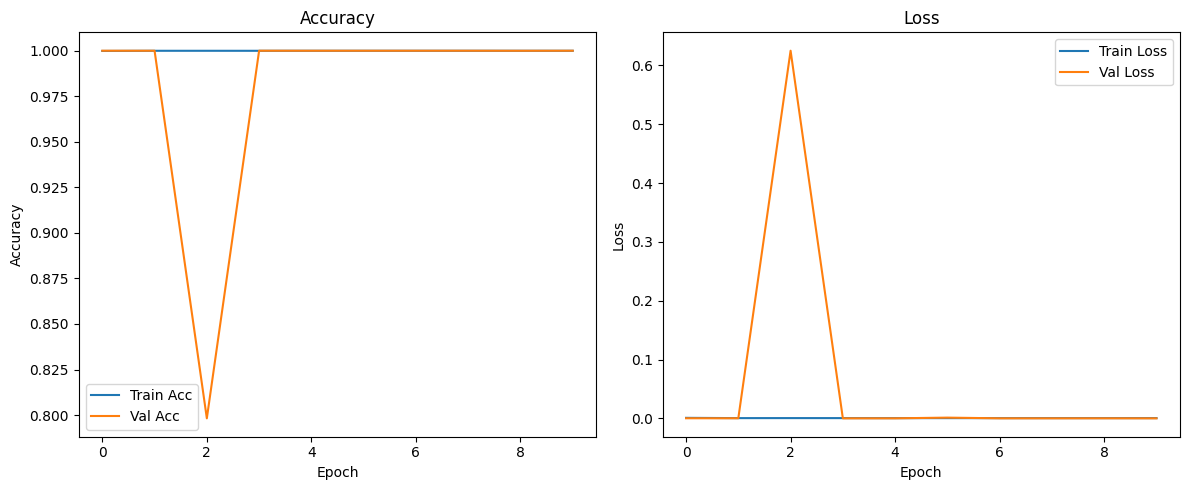

In [6]:
import matplotlib.pyplot as plt

#Step 4: Train the Model

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Step 5: Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


# Step 6: Plot Accuracy and Loss
plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy score
print("sklearn accuracy:", accuracy_score(y_test, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

37595/37595 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
Confusion Matrix:
[[821664      4]
 [    14 381353]]

True Negatives (Benign correctly classified): 821664
False Positives (Benign misclassified as malware): 4
False Negatives (Malware missed): 14
True Positives (Malware correctly identified): 381353
sklearn accuracy: 0.9999850378417918

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    821668
   Malicious       1.00      1.00      1.00    381367

    accuracy                           1.00   1203035
   macro avg       1.00      1.00      1.00   1203035
weighted avg       1.00      1.00      1.00   1203035



# 1D CNN Quant model

#Evaluate int8 1D CNN